# Implementation and Comparison of different Steganographic techniques

## Objetivo Principal

Nesse projeto iremos implementar diferentes técnicas de esteganografia para esconder dados em imagens digitais. Iremos comparar diferentes técnicas no domínio espacial e no frequencial com relação à qualidade do objeto resultante (objeto stego) e a distorção em relação à imagem original (imagem cover). Nosso objetivo é aprender sobre a aplicação de Esteganografia em Imagens assim como seus efeitos.

## Imagens de Entrada

Para essa aplicação, qualquer conjunto de imagens funcionaria. No nosso projeto, escolhemos 36 imagens da base de dados de imagens Cover do desafio do Kaggle [ALASKA2 Image Steganalysis](https://www.kaggle.com/c/alaska2-image-steganalysis/data) para imbutir com dados. Essa base foi escolhida por ter acesso simples à uma base organizada de imagens JPEG e por possuir grande similaridade ao tema deste projeto.

Para as demonstrações nas seções seguintes, será utilizada a imagem contida em [cover_images/20.jpg](https://github.com/eduardo550/SCC0251-FinalProject/blob/main/cover_images/20.jpg)

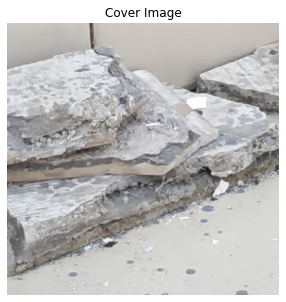

In [1]:
import numpy as np
import imageio as io
import matplotlib.pyplot as plt

cover_image = np.asarray(io.imread("cover_images/20.jpg"))

plt.rcParams['figure.figsize'] = [10, 5]
plt.title("Cover Image")
plt.axis("off")
plt.imshow(cover_image)

## Descrição de Passos e Métodos

Nesse projeto utilizamos arquivos de texto como dados secretos. Qualquer tipo de arquivo deve servir, mas o conteúdo textual deixa claro o funcionamento correto dos algoritmos. Foi utilizado como dado secreto o arquivo:
* [large.txt](testdata/large.txt). Conteúdo textual de H.P. Lovecraft. "The Call of Cthulhu", obra de acervo público. Aprox. 70 Kb.

In [2]:
import utils    # Módulo implementado nesse projeto, contém funções de conveniência fora dos algoritmos de esteganografia

# A função read_payload retorna um objeto bytes contendo o conteúdo do arquivo em binário, 
# com um cabeçalho adicional de 8 bytes que contém a quantidade de bytes do arquivo
payload = utils.read_payload("testdata/large.txt")
payload_size = len(payload)
print(f"Payload has {payload_size} bytes")

Payload has 68773 bytes


As medidas de distorção que serão utilizadas são o Mean Squared Error (mse) entre a imagem cover e imagem stego, e o Peak Signal to Noise Ratio(psnr), medida de distorção de sinais comumente encontrada na literatura. Elas são implementadas no módulo metrics.py, criado nesse projeto. Na demonstração, mostramos também o bitmap da imagem como exemplo de detectabilidade da adulteração.

Para cada técnica de esteganografia que escolhemos, foi implementada uma ferramenta que executa o seu algoritmo. Elas podem ser executadas independentemente, ou ser importadas como módulos, que é o que será feito nesse notebook. Cada módulo contém pelo menos as funções:
1. max_capacity(cover) -> retorna o número de bytes que a técnica comporta de acordo com a imagem cover.
2. embed(cover, payload) -> faz o ocultamento do payload na imagem, de acordo com a técnica escolhida. Antes de começar a ocultar o payload, checa se a imagem possui capacidade para ocultá-lo inteiro, com a validação utilizando max_capacity(). Retorna a imagem stego, em formato (R, G, B)
3. extract(stego) -> a partir de uma imagem stego, faz a extração do conteúdo binário escondido. A função assume que existe conteúdo válido dentro da imagem, e seu comportamento é indefinido caso contrário. Retorna um objeto bytes, com o conteúdo do payload original.

As técnicas de Esteganografia que foram implementadas são:
1. Least Significant Bit embedding.
2. Edge-based encoding, com embedding em 2 bits
3. Integer Wavelet Transform, com embedding no resultado de módulo entre coeficientes.

### Least Significant Bit (LSB)
A técnica mais famosa e mais simples, consiste em substituir o bit menos significativo de cada pixel em cada canal da imagem pelos bits do payload. Assim, como utilizamos o sistema (R, G, B) a capacidade máxima de uma imagem é igual a quantidade de pixels * 3 / 8. Foi implementada no módulo [lsb_embed.py](https://github.com/eduardo550/SCC0251-FinalProject/blob/main/lsb_embed.py)

In [3]:
import lsb_embed

lsb = lsb_embed.Steg(cover_image.copy())
lsb_max_capacity = lsb.max_capacity()
print(f"Cover has max embedding capacity of {lsb_max_capacity} bytes")

Cover has max embedding capacity of 98304.0 bytes


Gerando o objeto stego

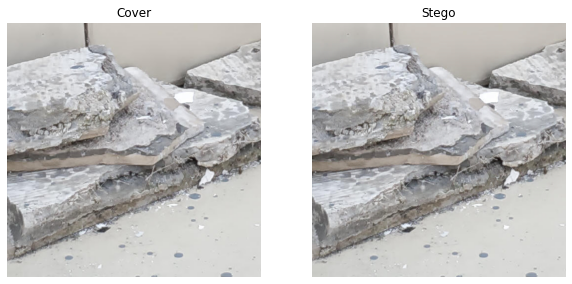

In [4]:
assert payload_size <= lsb_max_capacity

lsb_stego = np.asarray(lsb.embed(payload))

utils.plot_cover_stego(cover_image, lsb_stego)

Como esperado, as imagens não possuem diferenças visíveis ao olho nu. Porém, existem distorções grandes quando convertemos as imagens para bitmaps do bit menos significativo, o que faz essa técnica ser facilmente detectável com a transformação certa.

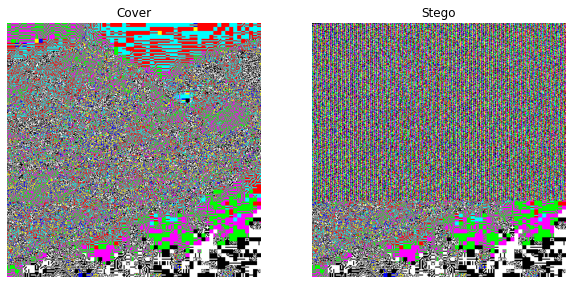

In [5]:
cover_bitmap = (cover_image & 1) * 255
lsb_bitmap = (lsb_stego & 1) * 255

utils.plot_cover_stego(cover_bitmap, lsb_bitmap)

Aqui fica claro que os bits da imagem stego são muito ordenados quando comparados ao ruído aleatório da cover. Esse é o comportamento esperado dessa operação.

Calculando as métricas de distorção

In [6]:
import metrics

lsb_mse = metrics.mse(cover_image, lsb_stego)
lsb_psnr = metrics.psnr(cover_image, lsb_stego)

print(f"MSE for this operation: {lsb_mse:.4f}")
print(f"PSNR for this operation: {lsb_psnr:.4f} dB")

MSE for this operation: 0.3496
PSNR for this operation: 52.6955 dB


Temos que a imagem possui uma distorção um pouco menor que a normalmente aceitável (valores de psnr aceitáveis caem acima de 60dB). Essas medidas são a base que as próximas técnicas precisam superar.

### Edge-based Encoding (EBE)
Essa técnica seleciona os pixels de borda para esconder os dados. A teoria é que o olho nu não irá perceber distorções médias em regiões de alta transição de intensidade (bordas). Para essa seleção, foi utilizado o filtro de Sobel para obter a lista de pixels de borda, e os 2 últimos bits são substituídos para compensar a redução de capacidade comparada a da técnica anterior. É implementada no módulo [ebe_embed.py](https://github.com/eduardo550/SCC0251-FinalProject/blob/main/ebe_embed.py).

A capacidade máxima depende da quantidade de pixels de borda, logo é variável com imagens Cover diferentes. Para a cover escolhida:

In [7]:
import ebe_embed

ebe = ebe_embed.Steg(cover_image.copy())
edge_capacity = ebe.max_capacity()
print(f"Cover has max embedding capacity of {edge_capacity} bytes")

Cover has max embedding capacity of 70359.75 bytes


Fazendo a operação

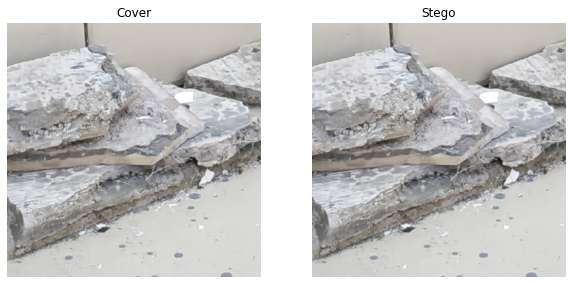

In [8]:
assert payload_size <= edge_capacity

ebe_stego = ebe.embed(payload)

utils.plot_cover_stego(cover_image, ebe_stego)

Novamente obtemos duas imagens quase idênticas. Porém, a distribuição de bits não é tão óbvia no bitmap, e é necessária uma técnica mais robusta de esteganálise para sua detecção.

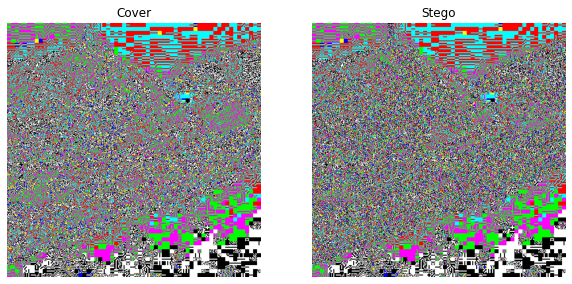

In [9]:
ebe_bitmap = (ebe_stego & 1) * 255

utils.plot_cover_stego(cover_bitmap, ebe_bitmap)

Calculando as métricas de distorção para EBE

In [10]:
ebe_mse = metrics.mse(cover_image, ebe_stego)
ebe_psnr = metrics.psnr(cover_image, ebe_stego)

print(f"MSE for this operation: {ebe_mse:.4f}")
print(f"PSNR for this operation: {ebe_psnr:.4f} dB")

MSE for this operation: 0.8739
PSNR for this operation: 48.7163 dB


Temos que a técnica EBE gera uma erro médio maior que LSB e PSNR comparável. Nesse exemplo, a EBE ganha de LSB em detectabilidade, enquanto perde um pouco em qualidade. Outros casos serão discutidos na seção de Resultados Obtidos.

### Integer Wavelet Transform (IWT)
Uma técnica experimental adaptada de [High quality image steganography on integer Haar Wavelet Transform using modulus function](https://ieeexplore.ieee.org/document/7407781). Ela difere das duas últimas pois o ocultamento acontece no domínio de frequências, assim verificar apenas os pixels não são suficientes para sua detecção. A imagem é transformada com uma adaptação de *Discrete Haar Wavelet Transform* utilizando um *lifting scheme*, que faz com que os coeficientes sejam inteiros. Isso é útil para a esteganografia pois os dados da imagem precisam estar na forma inteira para que seja possível fazer as operações em bits.

A IWT resulta em 4 faixas de coeficientes: cA, cH, cV, cD, que resultam da aplicação das operações em blocos 2x2 da imagem 2D
* cA = as médias dos pixels, na horizontal e vertical
* cH = as diferenças dos pixels horizontais (na mesma linha)
* cV = as diferenças dos pixels verticais (na mesma coluna)
* cD = a soma das diferenças cH e cD

O algoritmo é aplicado em cada canal de cores da imagem, para aumentar a capacidade de inclusão de dados. Cada canal é tratado como uma imagem grayscale 2D

Essa técnica também vai um passo além das outras no momento da inclusão do dado secreto. Ao invés de substituir apenas os bits menos significativos, o algoritmo divide a imagem em pares de coeficientes disjuntos, sendo que cada par é definido pelo pixel ij e seu vizinho i(j+1). Esses coeficientes são alterados para ij' e i(j+1)', de modo que bits do dado oculto se tornam o resultado da operação: ij' + i(j+1)' mod 2^b, sendo b o número de bits do dado. Após a alteração dos coeficientes, é aplicada a transformada inversa, e a imagem stego é obtida com qualidade comparável a Cover. A técnica é implementada em [wavelet_embed.py](https://github.com/eduardo550/SCC0251-FinalProject/blob/main/wavelet_embed.py).

A capacidade máxima para IWT é calculada com o número de coeficientes obtidos após a transformada / 2, pois o payload é obtido com os pares de coefs. Reduzindo mais ainda a capacidade, os coeficientes de cA de cada canal não são alterados, pois sua mudança causaria a maior distorção na imagem original.

In [11]:
import wavelet_embed

iwt_capacity = wavelet_embed.max_capacity(cover_image)

print(f"Cover has max embedding capacity of {iwt_capacity} bytes")

Cover has max embedding capacity of 73728 bytes


Geração da imagem manipulada

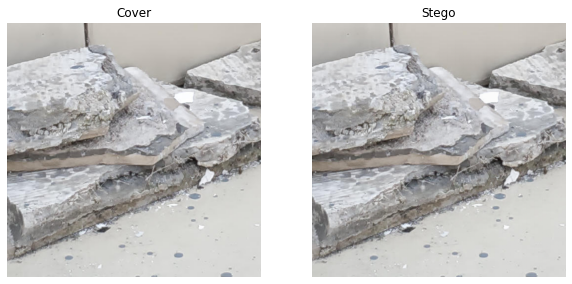

In [12]:
assert payload_size <= iwt_capacity

iwt_stego = wavelet_embed.embed(cover_image, payload)

utils.plot_cover_stego(cover_image, iwt_stego)

Como nas outras implementações, a imagem resultante não possui diferenças perceptíveis comparada à original. E novamente, a adulteração é menos perceptível no bitmap.

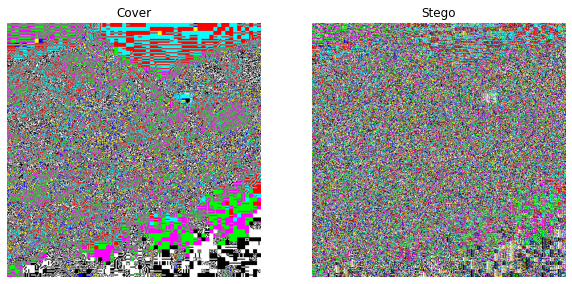

In [13]:
iwt_bitmap = (iwt_stego & 1) * 255

utils.plot_cover_stego(cover_bitmap, iwt_bitmap)

Temos uma grande alteração do bitmap, porém é mais parecida com resultados de uma compressão ao invés de uma operação maliciosa. 

Calculando as métricas de distorção:

In [14]:
iwt_mse = metrics.mse(cover_image, iwt_stego)
iwt_psnr = metrics.psnr(cover_image, iwt_stego)

print(f"MSE for this operation: {iwt_mse:.4f}")
print(f"PSNR for this operation: {iwt_psnr:.4f} dB")

MSE for this operation: 0.7225
PSNR for this operation: 49.5084 dB


Esses resultados são equivalentes aos obtidos por EBE. Temos que essa técnica ganha em detectabilidade e capacidade, sem grande melhora de qualidade da imagem stego.

#### Apresentando cada imagem lado a lado

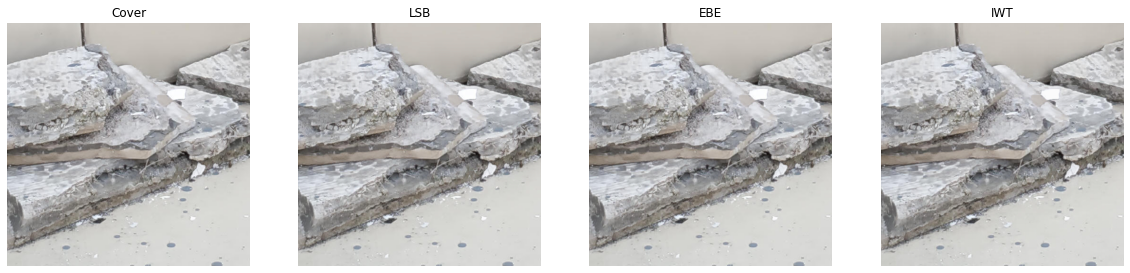

In [15]:
fig = plt.figure(figsize=(20, 10))

fig.add_subplot(1, 4, 1)
plt.axis("off")
plt.title("Cover")
plt.imshow(cover_image)
fig.add_subplot(1, 4, 2)
plt.axis("off")
plt.title("LSB")
plt.imshow(lsb_stego)
fig.add_subplot(1, 4, 3)
plt.axis("off")
plt.title("EBE")
plt.imshow(ebe_stego)
fig.add_subplot(1, 4, 4)
plt.axis("off")
plt.title("IWT")
plt.imshow(iwt_stego)

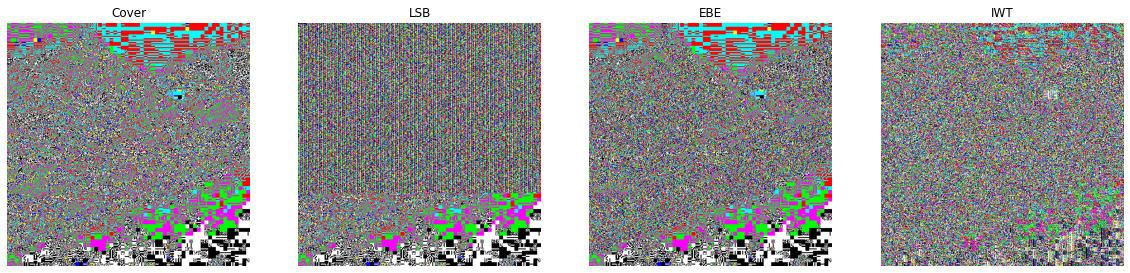

In [16]:
fig = plt.figure(figsize=(20, 10))

fig.add_subplot(1, 4, 1)
plt.axis("off")
plt.title("Cover")
plt.imshow(cover_bitmap)
fig.add_subplot(1, 4, 2)
plt.axis("off")
plt.title("LSB")
plt.imshow(lsb_bitmap)
fig.add_subplot(1, 4, 3)
plt.axis("off")
plt.title("EBE")
plt.imshow(ebe_bitmap)
fig.add_subplot(1, 4, 4)
plt.axis("off")
plt.title("IWT")
plt.imshow(iwt_bitmap)

## Resultados obtidos 

Aplicamos cada técnica nas imagens em [cover_images/](https://github.com/eduardo550/SCC0251-FinalProject/tree/main/cover_images). Uma tabela foi construída com os resultados de mse e psnr para cada imagem. Ela pode ser encontrada no arquivo [results.csv](https://github.com/eduardo550/SCC0251-FinalProject/blob/main/results.csv)

In [17]:
import pandas as pd

results_table = pd.read_csv("results.csv", index_col=0)
results_table

,lsb_mse,lsb_psnr,ebe_mse,ebe_psnr,iwt_mse,iwt_psnr
01.jpg,0.349808,52.692509,0.740485,49.435642,0.676216,49.761555
02.jpg,0.350745,52.646761,NaN,NaN,0.683994,49.711886
03.jpg,0.349725,50.797809,0.810045,47.149988,0.678303,47.920841
04.jpg,0.350816,52.680009,NaN,NaN,0.702264,49.631669
05.jpg,0.350211,52.687508,NaN,NaN,0.686567,49.695583
07.jpg,0.350335,48.691677,NaN,NaN,0.676781,45.777920
08.jpg,0.349813,52.692446,NaN,NaN,1.010743,48.050265
09.jpg,0.349859,52.519875,NaN,NaN,0.694903,49.539558
10.jpg,0.350332,52.686010,0.867488,48.748171,0.710701,49.545541
11.jpg,0.349327,52.561152,NaN,NaN,0.718587,49.428679


Primeiramente, a quantidade de NaN nas colunas de Edge-Based Encoding se deu pois a capacidade da imagem foi menor que o suficiente para o dado secreto escolhido. Para as linhas que obtiveram resultados, a distorção foi maior que a da LSB em todos os casos, e se comparado com IWT, teve uma variação maior. Isso deixa claro que a escolha de uma imagem cover é importante para o bom funcionamento do algoritmo.

Os resultados da IWT demonstram quase o exato oposto. Para todos os exemplos, a PSNR ficou entre 48-50 sem uma grande variação. Esse fator, combinado com a maior capacidade e menor detectabilidade, prova que é a melhor técnica para uma cover aleatória.

Porém, em termos de distorção da imagem original, nenhuma superou a técnica de LSB. Em cada caso a LSB obteve melhores resultados de distorção, com MSE menor e PSNR maior. Concluímos a partir desse experimento que a adição de complexidade maior não ajuda com a qualidade da imagem final, o que foi surpreendente e contraditório com as nossas suposições iniciais.

## Nomes e Papéis
* Eduardo de Sousa Siqueira		nUSP: 9278299   Implementação de IWT e construção do Final Report
* Igor Barbosa Grécia Lúcio		nUSP: 9778821   Implementação de LSB e Edge_encoding